Connected to Python 3.12.4

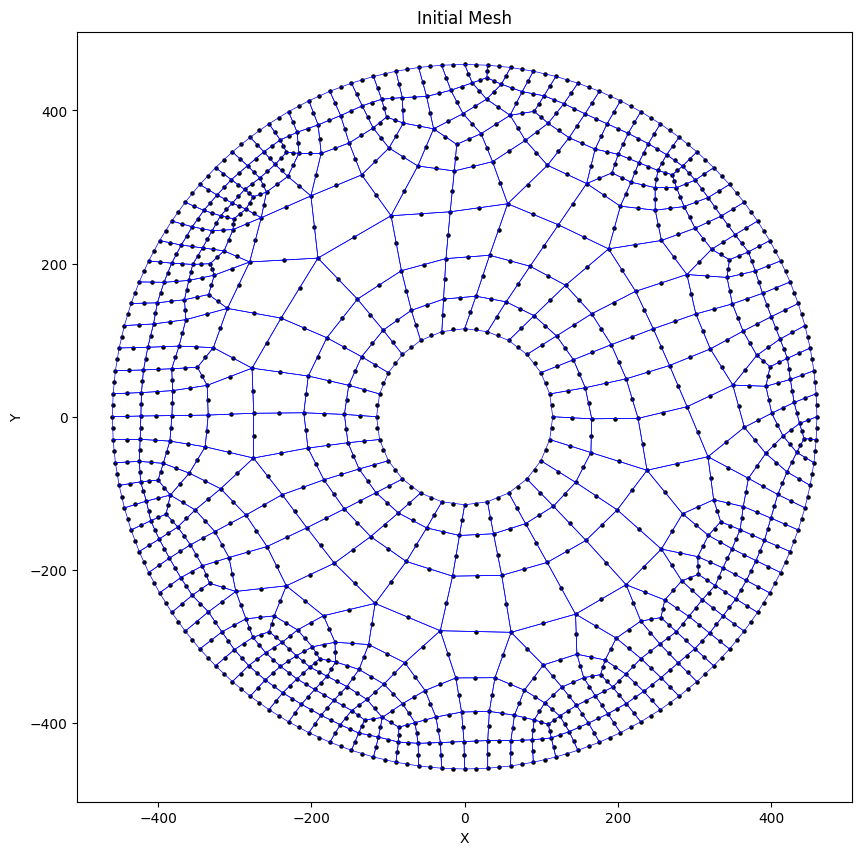

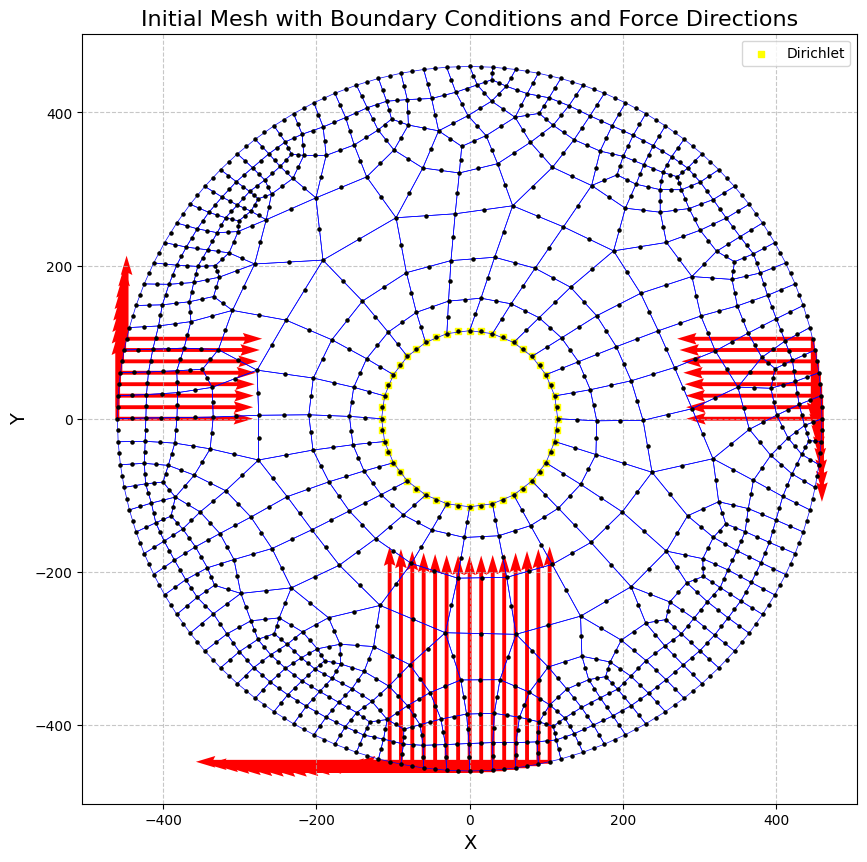

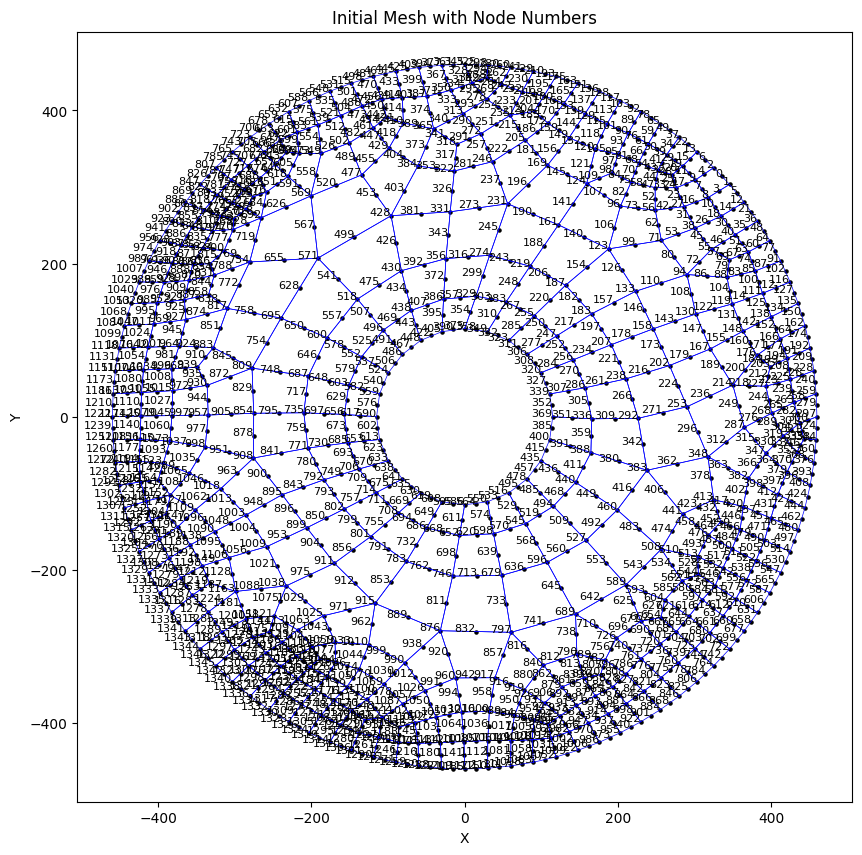

Dirichlet boundary conditions (drlt):
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])
Neumann boundary conditions (neum):
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])
u: tensor([ 2.1901e-09, -3.4406e-09,  2.0443e-09,  ..., -4.4413e-09,
        -2.2843e-09,  7.1018e-10])


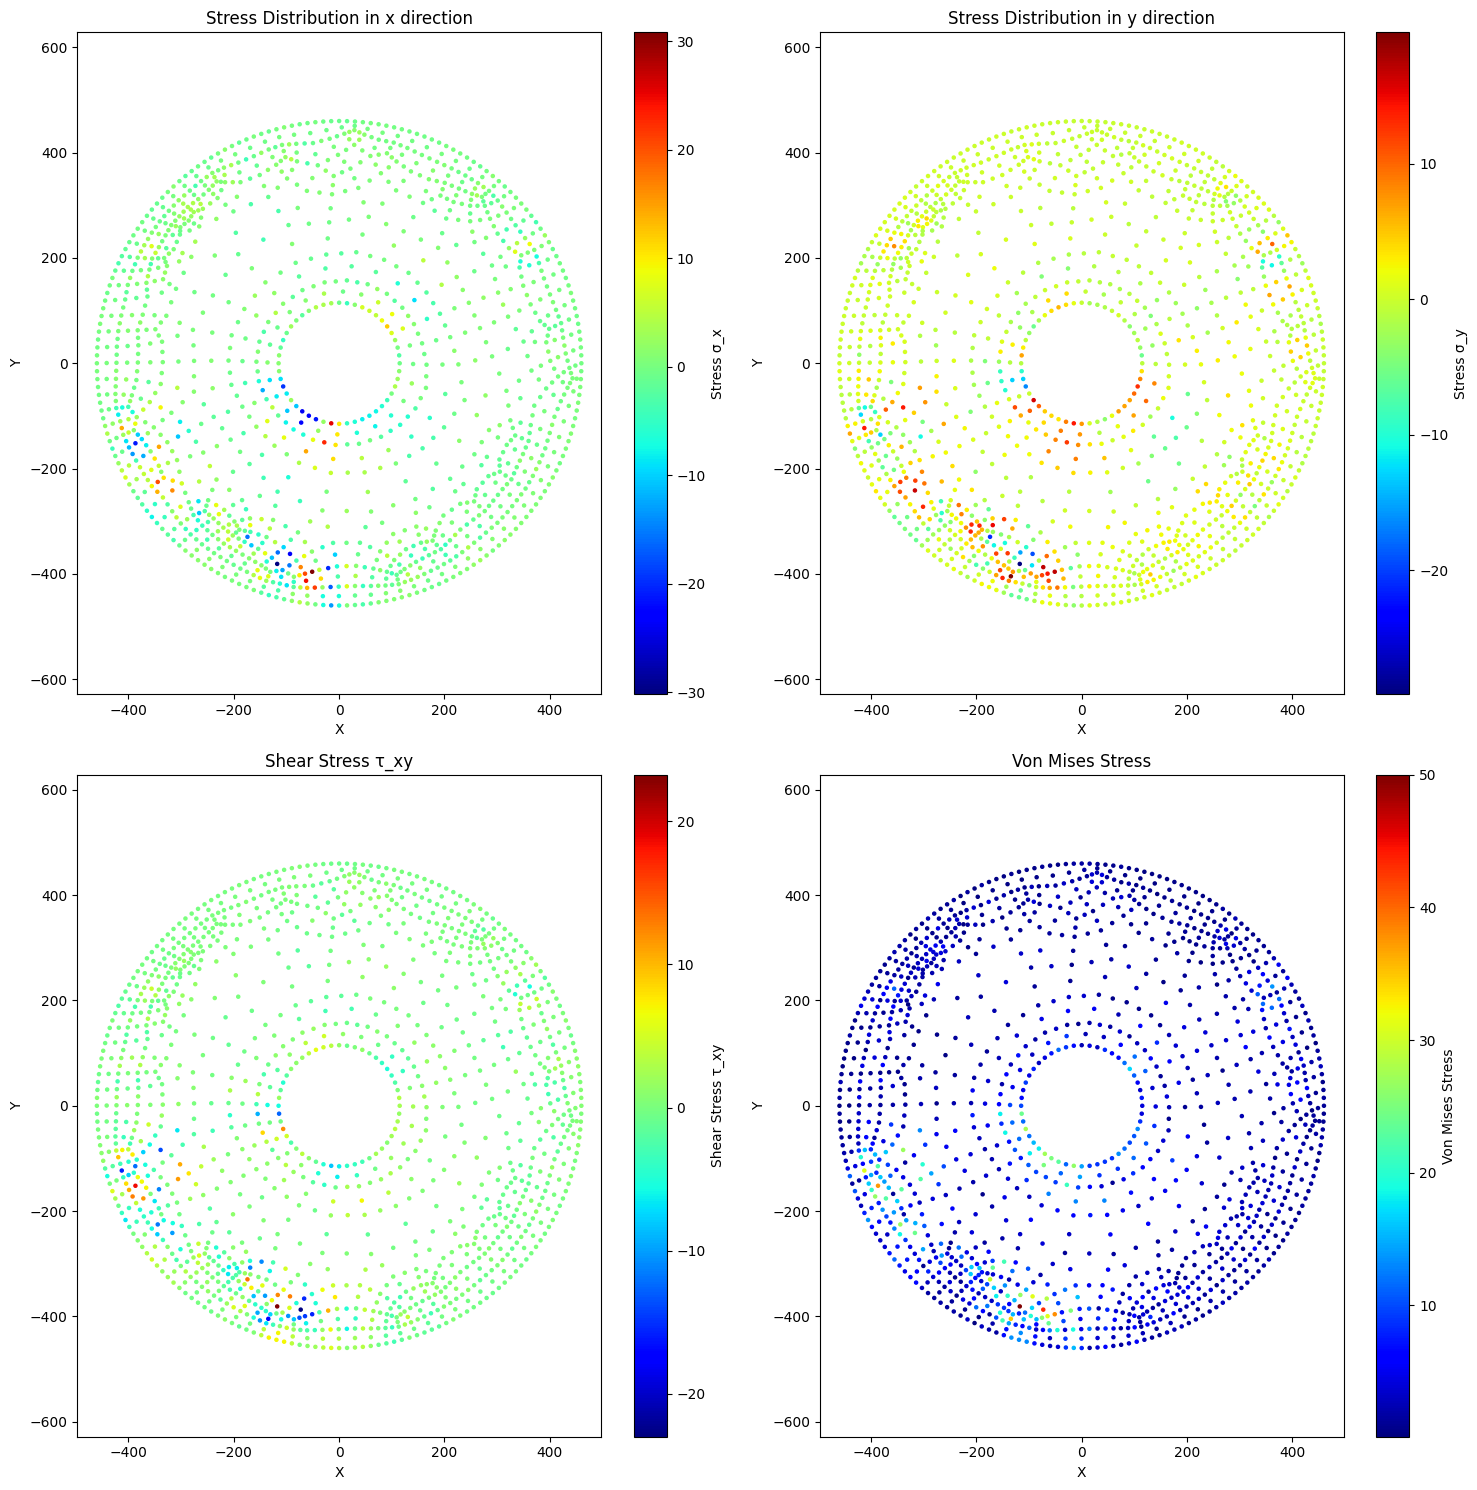

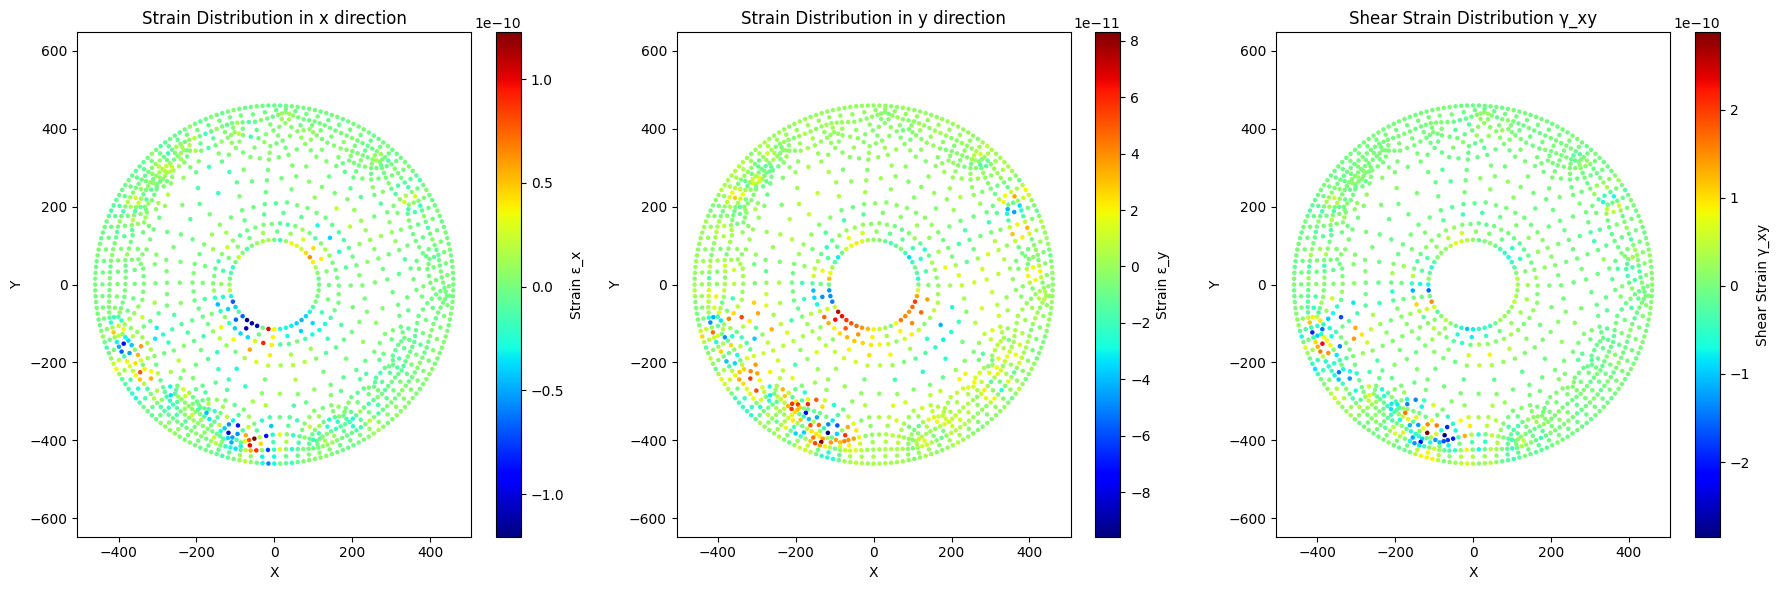

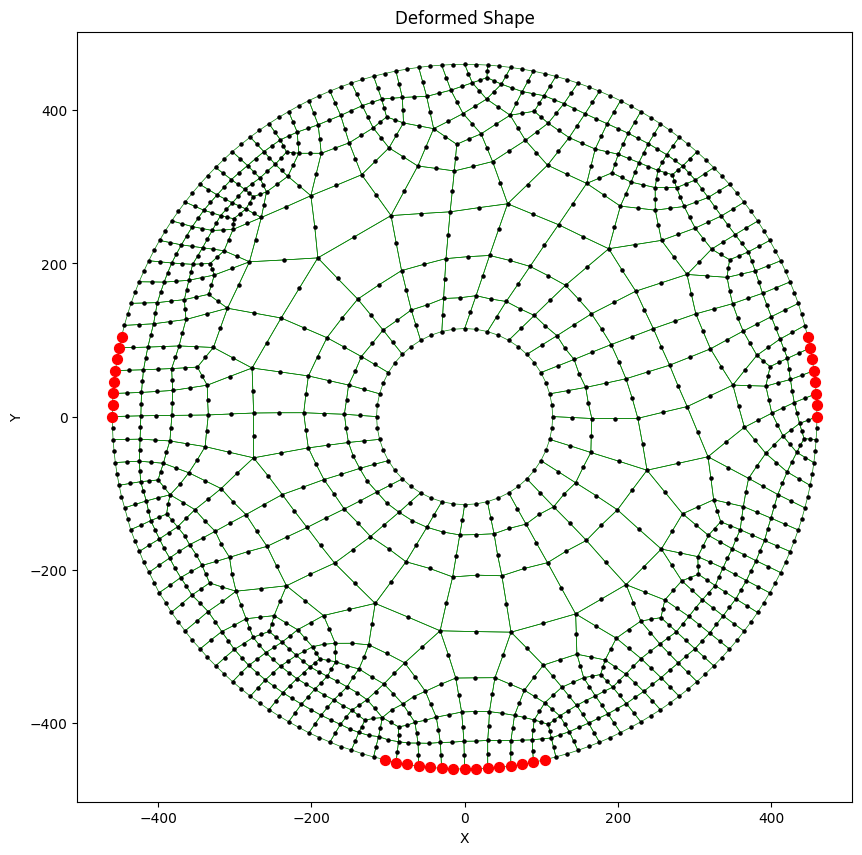

<Figure size 1200x600 with 0 Axes>

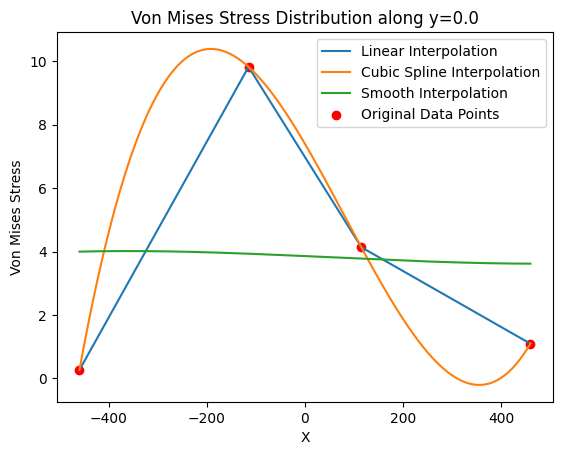

<Figure size 1200x600 with 0 Axes>

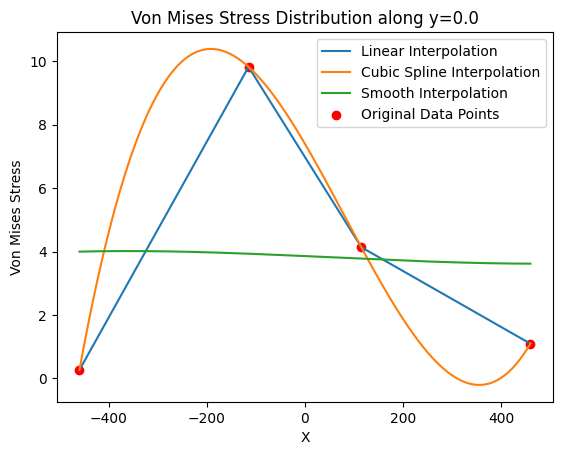

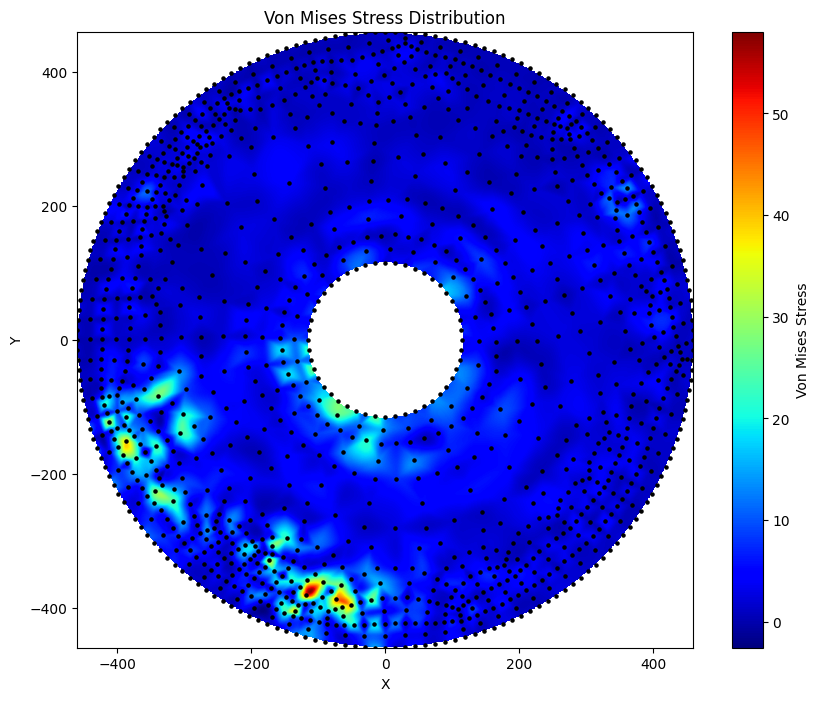

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import time as timemodule
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import griddata
torch.set_default_dtype(torch.float64)
torch.set_num_threads(4)
toplot = True
disp_scaling = 3*1e7
#tdm = 2

# Function to read data from a .msh file
def read_msh_file(filename):
    nodes = []
    elements = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        reading_nodes = False
        reading_elements = False
        for line in lines:
            if line.startswith('Coordinates'):
                reading_nodes = True
                reading_elements = False
                continue
            if line.startswith('Elements'):
                reading_nodes = False
                reading_elements = True
                continue
            if reading_nodes and line.strip() and not line.startswith('MESH'):
                parts = line.split()
                if len(parts) >= 4:
                    nodes.append([float(parts[1]), float(parts[2])])
            if reading_elements and line.strip() and not line.startswith('Elements'):
                parts = line.split()
                if len(parts) >= 9:
                    elements.append([int(p) - 1 for p in parts[1:9]])  # Convert to zero-based indexing
    return np.array(nodes), np.array(elements)

msh_file = 'gid_mesh/data_new.msh'

# Read nodes and elements
x, elems = read_msh_file(msh_file)
x = torch.from_numpy(x)
elems = torch.from_numpy(elems).to(torch.long)

# Plot initial mesh
plt.figure(figsize=(10, 10))
for elem in elems:
    elem = elem.numpy()
    plt.plot(x[elem[[0, 1, 2, 3, 0]], 0].numpy(), x[elem[[0, 1, 2, 3, 0]], 1].numpy(), 'blue', linewidth=0.5)
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c='black', s=5)
plt.title('Initial Mesh')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

def shape_functions(xi, eta):
    N = torch.zeros(8)
    N[0] = (1 - xi) * (1 - eta) * (-1 - xi - eta) / 4
    N[1] = (1 + xi) * (1 - eta) * (-1 + xi - eta) / 4
    N[2] = (1 + xi) * (1 + eta) * (-1 + xi + eta) / 4
    N[3] = (1 - xi) * (1 + eta) * (-1 - xi + eta) / 4
    N[4] = (1 - xi ** 2) * (1 - eta) / 2
    N[5] = (1 + xi) * (1 - eta ** 2) / 2
    N[6] = (1 - xi ** 2) * (1 + eta) / 2
    N[7] = (1 - xi) * (1 - eta ** 2) / 2
    return N

def shape_function_derivatives(xi, eta):
    dN_dxi = torch.zeros(8)
    dN_deta = torch.zeros(8)
    dN_dxi[0] = (1 - eta) * (-1 - xi - eta) / 4 + (1 - xi) * (1 - eta) / 4
    dN_dxi[1] = (1 - eta) * (-1 + xi - eta) / 4 + (1 + xi) * (1 - eta) / 4
    dN_dxi[2] = (1 + eta) * (-1 + xi + eta) / 4 + (1 + xi) * (1 + eta) / 4
    dN_dxi[3] = (1 + eta) * (-1 - xi + eta) / 4 + (1 - xi) * (1 + eta) / 4
    dN_dxi[4] = -xi * (1 - eta)
    dN_dxi[5] = (1 - eta ** 2) / 2
    dN_dxi[6] = -xi * (1 + eta)
    dN_dxi[7] = -(1 - eta ** 2) / 2

    dN_deta[0] = (1 - xi) * (-1 - xi - eta) / 4 + (1 - xi) * (1 - eta) / 4
    dN_deta[1] = (1 + xi) * (-1 + xi - eta) / 4 - (1 + xi) * (1 - eta) / 4
    dN_deta[2] = (1 + xi) * (-1 + xi + eta) / 4 + (1 + xi) * (1 + eta) / 4
    dN_deta[3] = (1 - xi) * (-1 - xi + eta) / 4 + (1 - xi) * (1 + eta) / 4
    dN_deta[4] = -(1 - xi ** 2) / 2
    dN_deta[5] = -eta * (1 + xi)
    dN_deta[6] = (1 - xi ** 2) / 2
    dN_deta[7] = -eta * (1 - xi)
    return dN_dxi, dN_deta


def gauss_quadrature():
    
    gauss_points = torch.tensor([
        [-1 / math.sqrt(3), -1 / math.sqrt(3)],
        [1 / math.sqrt(3), -1 / math.sqrt(3)],
        [1 / math.sqrt(3), 1 / math.sqrt(3)],
        [-1 / math.sqrt(3), 1 / math.sqrt(3)]
    ])
    weights = torch.tensor([1, 1, 1, 1])
    return gauss_points, weights
    
    # def gauss_quadrature():
    '''gauss_points = torch.tensor([
        [-math.sqrt(3 / 5), -math.sqrt(3 / 5)],
        [0.0, -math.sqrt(3 / 5)],
        [math.sqrt(3 / 5), -math.sqrt(3 / 5)],
        [-math.sqrt(3 / 5), 0.0],
        [0.0, 0.0],
        [math.sqrt(3 / 5), 0.0],
        [-math.sqrt(3 / 5), math.sqrt(3 / 5)],
        [0.0, math.sqrt(3 / 5)],
        [math.sqrt(3 / 5), math.sqrt(3 / 5)]
    ])

    weights = torch.tensor([
        5 / 9 * 5 / 9, 8 / 9 * 5 / 9, 5 / 9 * 5 / 9,
        5 / 9 * 8 / 9, 8 / 9 * 8 / 9, 5 / 9 * 8 / 9,
        5 / 9 * 5 / 9, 8 / 9 * 5 / 9, 5 / 9 * 5 / 9
    ])

    return gauss_points, weights'''

def jacobian(x, dN_dxi, dN_deta):
    J = torch.zeros(2, 2)
    nen = x.shape[0]  # 获取单元的节点数
    for i in range(nen):
        J[0, 0] += dN_dxi[i] * x[i, 0]
        J[0, 1] += dN_dxi[i] * x[i, 1]
        J[1, 0] += dN_deta[i] * x[i, 0]
        J[1, 1] += dN_deta[i] * x[i, 1]
    return J

def calculate_stress(B, D, u_elem):
    strain = B @ u_elem  # 计算应变
    stress = D @ strain  # 计算应力
    return stress, strain

E = 210e9
nu = 0.3
ndf = 2
ndm = 2
global tdm
tdm = 2
nen = 8
outer_diameter = 920.0
inner_diameter = 230.0
num_nodes = x.shape[0]
drlt = torch.zeros(num_nodes, 2)
tolerance =1e-6
inner_nodes = torch.where(x[:, 0] ** 2 + x[:, 1] ** 2 <= (inner_diameter / 2) ** 2 + tolerance)[0]
for node in inner_nodes:
    drlt[node, 0] = 1
    drlt[node, 1] = 1
# Define loads
N_a = 62.5e3
N_b = 3.5e3
N_c = 3.5e3
mu_1 = 0.2
mu_2 = 0.35
mu_3 = 0.35
F_a = mu_1 * N_a
F_b = mu_2 * N_b
F_c=mu_3*N_c
node_tolerance = 12.5
neum = torch.zeros(num_nodes, 2)
# Apply N_a and F_a at the bottom node
bottom_nodes = torch.where(torch.abs(x[:, 1] - torch.min(x[:, 1])) <= node_tolerance)[0]
for node in bottom_nodes:
    neum[node.item(), 1] += N_a / len(bottom_nodes)
    neum[node.item(), 0] -= F_a / len(bottom_nodes)

# Apply N_b and F_b at 1/6 segments on the sides
side_nodes_left = torch.where((torch.abs(x[:, 0] - torch.min(x[:, 0])) <= node_tolerance) & (x[:, 1] >= 0))[0]
side_nodes_right = torch.where((torch.abs(x[:, 0] - torch.max(x[:, 0])) <= node_tolerance) & (x[:, 1] >= 0))[0]
for node in side_nodes_left:
    neum[node.item(), 1] += F_b / len(side_nodes_left)
    neum[node.item(), 0] += N_b / len(side_nodes_left)

for node in side_nodes_right:
    neum[node.item(), 1] -= F_c / len(side_nodes_right)
    neum[node.item(), 0] -= N_c / len(side_nodes_right)
plt.figure(figsize=(10, 10))  # 调整图像大小以提高清晰度
for elem in elems:
    elem = elem.numpy()  # Convert to numpy for plotting
    plt.plot(x[elem[[0, 1, 2, 3, 0]], 0].numpy(), x[elem[[0, 1, 2, 3, 0]], 1].numpy(), 'blue', linewidth=0.5)  # 用细蓝线绘制网格
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c='black', s=5, zorder=5)  # 用黑色标记节点

# 标记Dirichlet边界条件节点
for node in inner_nodes:
    plt.scatter(x[node, 0].numpy(), x[node, 1].numpy(), c='yellow', marker='s', s=15, label='Dirichlet' if node == inner_nodes[0] else "")


# 使用箭头显示Neumann边界条件的力方向
for node in bottom_nodes:
    plt.quiver(x[node, 0].numpy(), x[node, 1].numpy(), -F_a / len(bottom_nodes)*3,0,color='red', scale=1e4,width=0.005)
    plt.quiver(x[node, 0].numpy(), x[node, 1].numpy(),  0,N_a / len(bottom_nodes)/1.5, color='red', scale=1e4,width=0.005)
for node in side_nodes_left:
    plt.quiver(x[node, 0].numpy(), x[node, 1].numpy(), 0, F_b*7/ len(side_nodes_left), color='red', scale=1e4,width=0.005)
    plt.quiver(x[node, 0].numpy(), x[node, 1].numpy(), N_b*4/ len(side_nodes_left), 0, color='red', scale=1e4,width=0.005)
for node in side_nodes_right:
    plt.quiver(x[node.item(), 0].numpy(), x[node.item(), 1].numpy(), 0, -F_c*7/ len(side_nodes_right), color='red', scale=1e4,width=0.005)
    plt.quiver(x[node.item(), 0].numpy(), x[node.item(), 1].numpy(), -N_c*4/ len(side_nodes_right), 0, color='red', scale=1e4,width=0.005)

# 添加图例和轴标签
plt.title('Initial Mesh with Boundary Conditions and Force Directions', fontsize=16)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.7)  # 添加网格线，提高对比度
plt.legend()
plt.show()
plt.figure(figsize=(10, 10))
for elem in elems:
    elem = elem.numpy()  # Convert to numpy for plotting
    plt.plot(x[elem[[0, 1, 2, 3, 0]], 0].numpy(), x[elem[[0, 1, 2, 3, 0]], 1].numpy(), 'blue', linewidth=0.5)
for i, (xi, yi) in enumerate(x):
    plt.text(xi.item(), yi.item(), str(i), fontsize=8, ha='right')
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c='black', s=5)
plt.title('Initial Mesh with Node Numbers')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

print("Dirichlet boundary conditions (drlt):")
print(drlt)
print("Neumann boundary conditions (neum):")
print(neum)

# Gauss quadrature
gauss_points, weights = gauss_quadrature()
# Initialize stiffness matrix and force vector
K = torch.zeros((x.shape[0] * ndf, x.shape[0] * ndf), dtype=torch.float64)
F = torch.zeros(x.shape[0] * ndf, dtype=torch.float64)
# Apply boundary conditions
for node in range(num_nodes):
    F[2 * node] += neum[node, 0]
    F[2 * node + 1] += neum[node, 1]

# 计算单元刚度矩阵并装配全局刚度矩阵
for elem in elems:
    Ke = torch.zeros((nen * ndf, nen * ndf), dtype=torch.float64)
    xe = x[elem, :]
    for gp, w in zip(gauss_points, weights):
        xi, eta = gp
        N = shape_functions(xi, eta)
        dN_dxi, dN_deta = shape_function_derivatives(xi, eta)
        J = jacobian(xe, dN_dxi, dN_deta)
        detJ = torch.det(J)
        invJ = torch.inverse(J)
        dN_dx = torch.zeros(nen, dtype=torch.float64)
        dN_dy = torch.zeros(nen, dtype=torch.float64)
        for i in range(nen):
            dN_dx[i] = invJ[0, 0] * dN_dxi[i] + invJ[0, 1] * dN_deta[i]
            dN_dy[i] = invJ[1, 0] * dN_dxi[i] + invJ[1, 1] * dN_deta[i]
        B = torch.zeros((3, nen * ndf), dtype=torch.float64)
        for i in range(nen):
            B[0, 2 * i] = dN_dx[i]
            B[1, 2 * i + 1] = dN_dy[i]
            B[2, 2 * i] = dN_dy[i]
            B[2, 2 * i + 1] = dN_dx[i]
        D = (E / (1 - nu ** 2)) * torch.tensor([[1, nu, 0], [nu, 1, 0], [0, 0, (1 - nu) / 2]], dtype=torch.float64)
        Ke += B.t().mm(D).mm(B) * detJ * w
    for i in range(nen):
        for j in range(nen):
            K[2 * elem[i]:2 * elem[i] + 2, 2 * elem[j]:2 * elem[j] + 2] += Ke[2 * i:2 * i + 2, 2 * j:2 * j + 2]

# 应用Dirichlet边界条件
for node in range(num_nodes):
    if drlt[node, 0] == 1:  # x方向固定
        idx = 2 * node
        K[idx, :] = 0
        K[:, idx] = 0
        K[idx, idx] = 1
        F[idx] = 0
    if drlt[node, 1] == 1:  # y方向固定
        idx = 2 * node + 1
        K[idx, :] = 0
        K[:, idx] = 0
        K[idx, idx] = 1
        F[idx] = 0

# 求解系统方程
u = torch.linalg.solve(K, F)
print("u:",u)
###### Post-processing/ plots ########
u_reshaped = torch.reshape(u, (-1, 2))
x_disped = x + disp_scaling * u_reshaped
stress_all_nodes = [torch.zeros((3,), dtype=torch.float64) for _ in range(num_nodes)]
strain_all_nodes = [torch.zeros((3,), dtype=torch.float64) for _ in range(num_nodes)]
node_contributions = [0 for _ in range(num_nodes)]
for elem in elems:
    xe = x[elem, :]
    ue = u_reshaped[elem].reshape(-1)
    for gp, w in zip(gauss_points, weights):
        xi, eta = gp
        dN_dxi, dN_deta = shape_function_derivatives(xi, eta)
        J = jacobian(xe, dN_dxi, dN_deta)
        detJ = torch.det(J)
        invJ = torch.inverse(J)
        dN_dx = torch.zeros(nen, dtype=torch.float64)
        dN_dy = torch.zeros(nen, dtype=torch.float64)
        for i in range(nen):
            dN_dx[i] = invJ[0, 0] * dN_dxi[i] + invJ[0, 1] * dN_deta[i]
            dN_dy[i] = invJ[1, 0] * dN_dxi[i] + invJ[1, 1] * dN_deta[i]
        B = torch.zeros((3, nen * ndf), dtype=torch.float64)
        for i in range(nen):
            B[0, 2 * i] = dN_dx[i]
            B[1, 2 * i + 1] = dN_dy[i]
            B[2, 2 * i] = dN_dy[i]
            B[2, 2 * i + 1] = dN_dx[i]
        stress, strain = calculate_stress(B, D, ue)
        for i in range(nen):
            stress_all_nodes[elem[i]] += stress / len(gauss_points)
            strain_all_nodes[elem[i]] += strain / len(gauss_points)
            node_contributions[elem[i]] += 1

# 平均每个节点的应力和应变
for idx in range(num_nodes):
    if node_contributions[idx] > 0:
        stress_all_nodes[idx] /= node_contributions[idx]
        strain_all_nodes[idx] /= node_contributions[idx]

# 可视化应力分布
stress_x_all_nodes = torch.tensor([s[0] for s in stress_all_nodes])
stress_y_all_nodes = torch.tensor([s[1] for s in stress_all_nodes])
tau_xy_all_nodes = torch.tensor([s[2] for s in stress_all_nodes])
'''
plt.figure()
#plt.scatter(x_disped[:, 0].numpy(), x_disped[:, 1].numpy(), c=stress_x_all_nodes.numpy(), cmap='jet', s=5)
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=stress_x_all_nodes.numpy(), cmap='jet', s=5)
plt.colorbar(label='Stress σ_x')
plt.title('Deformed Shape with Stress Distribution in x direction')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

plt.figure()
#plt.scatter(x_disped[:, 0].numpy(), x_disped[:, 1].numpy(), c=stress_y_all_nodes.numpy(), cmap='jet', s=5)
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=stress_y_all_nodes.numpy(), cmap='jet', s=5)
plt.colorbar(label='Stress σ_y')
plt.title('Deformed Shape with Stress Distribution in y direction')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

plt.figure()
#plt.scatter(x_disped[:, 0].numpy(), x_disped[:, 1].numpy(), c=stress_y_all_nodes.numpy(), cmap='jet', s=5)
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=tau_xy_all_nodes.numpy(), cmap='jet', s=5)
plt.colorbar(label='Shear Stress τ_xy')
plt.title('Shear Stress τ_xy')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()
## 计算等效应力并绘制
def von_mises_stress(stress):
    sigma_x, sigma_y, tau_xy = stress[0], stress[1], stress[2]
    return torch.sqrt(sigma_x**2 + sigma_y**2 - sigma_x * sigma_y + 3 * tau_xy**2)
von_mises_stress_all_nodes = torch.tensor([von_mises_stress(s) for s in stress_all_nodes])
plt.figure()
#plt.scatter(x_disped[:, 0].numpy(), x_disped[:, 1].numpy(), c=stress_y_all_nodes.numpy(), cmap='jet', s=5)
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=von_mises_stress_all_nodes.numpy(), cmap='jet', s=5)
plt.colorbar(label='Stress')
plt.title('Von Mises Stress')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()'''
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# σ_x应力分布图
axs[0, 0].scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=stress_x_all_nodes.numpy(), cmap='jet', s=5)
axs[0, 0].set_title('Stress Distribution in x direction')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')
axs[0, 0].axis('equal')
fig.colorbar(axs[0, 0].collections[0], ax=axs[0, 0], label='Stress σ_x')

# σ_y应力分布图
axs[0, 1].scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=stress_y_all_nodes.numpy(), cmap='jet', s=5)
axs[0, 1].set_title('Stress Distribution in y direction')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')
axs[0, 1].axis('equal')
fig.colorbar(axs[0, 1].collections[0], ax=axs[0, 1], label='Stress σ_y')

# τ_xy剪应力分布图
axs[1, 0].scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=tau_xy_all_nodes.numpy(), cmap='jet', s=5)
axs[1, 0].set_title('Shear Stress τ_xy')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
axs[1, 0].axis('equal')
fig.colorbar(axs[1, 0].collections[0], ax=axs[1, 0], label='Shear Stress τ_xy')

# Von Mises应力分布图
def von_mises_stress(stress):
    sigma_x, sigma_y, tau_xy = stress[0], stress[1], stress[2]
    return torch.sqrt(sigma_x**2 + sigma_y**2 - sigma_x * sigma_y + 3 * tau_xy**2)
von_mises_stress_all_nodes = torch.tensor([von_mises_stress(s) for s in stress_all_nodes])
axs[1, 1].scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=von_mises_stress_all_nodes.numpy(), cmap='jet', s=5)
axs[1, 1].set_title('Von Mises Stress')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')
axs[1, 1].axis('equal')
fig.colorbar(axs[1, 1].collections[0], ax=axs[1, 1], label='Von Mises Stress')

# 调整布局以防止重叠
plt.tight_layout()
plt.show()
# 可视化应变分布
strain_x_all_nodes = torch.tensor([e[0] for e in strain_all_nodes])
strain_y_all_nodes = torch.tensor([e[1] for e in strain_all_nodes])
gamma_xy_all_nodes = torch.tensor([e[2] for e in strain_all_nodes])
'''plt.figure()
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=strain_x_all_nodes.numpy(), cmap='jet', s=5)
plt.colorbar(label='Strain ε_x')
plt.title('Strain Distribution in x direction')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

plt.figure()
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=strain_y_all_nodes.numpy(), cmap='jet', s=5)
plt.colorbar(label='Strain ε_y')
plt.title('Strain Distribution in y direction')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

plt.figure()
plt.scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=gamma_xy_all_nodes.numpy(), cmap='jet', s=5)
plt.colorbar(label='Shear Strain γ_xy')
plt.title('Shear Strain Distribution γ_xy')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()'''
# 创建一个1x3的图像网格
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# ε_x应变分布图
axs[0].scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=strain_x_all_nodes.numpy(), cmap='jet', s=5)
axs[0].set_title('Strain Distribution in x direction')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].axis('equal')
fig.colorbar(axs[0].collections[0], ax=axs[0], label='Strain ε_x')

# ε_y应变分布图
axs[1].scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=strain_y_all_nodes.numpy(), cmap='jet', s=5)
axs[1].set_title('Strain Distribution in y direction')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].axis('equal')
fig.colorbar(axs[1].collections[0], ax=axs[1], label='Strain ε_y')

# γ_xy剪应变分布图
axs[2].scatter(x[:, 0].numpy(), x[:, 1].numpy(), c=gamma_xy_all_nodes.numpy(), cmap='jet', s=5)
axs[2].set_title('Shear Strain Distribution γ_xy')
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
axs[2].axis('equal')
fig.colorbar(axs[2].collections[0], ax=axs[2], label='Shear Strain γ_xy')

# 调整布局以防止重叠
plt.tight_layout()
plt.show()
#变形后
plt.figure(figsize=(10, 10))
for elem in elems:
    elem = elem.numpy()  # Convert to numpy for plotting
    #plt.plot(x_disped[elem[[0, 1, 2, 3, 0]], 0].numpy(), x_disped[elem[[0, 1, 2, 3, 0]], 1].numpy(), 'blue',linewidth=0.5)
    plt.plot(x_disped[elem[[0, 4, 1, 5, 2, 6, 3, 7, 0]], 0].numpy(),x_disped[elem[[0, 4, 1, 5, 2, 6, 3, 7, 0]], 1].numpy(), 'green',linewidth=0.5)
plt.scatter(x_disped[:, 0].numpy(), x_disped[:, 1].numpy(), c='black',s=5,zorder=5)
plt.scatter(x_disped[bottom_nodes, 0].numpy(), x_disped[bottom_nodes, 1].numpy(), c='red', s=50, zorder=10)  # 高亮显示底部节点
plt.scatter(x_disped[side_nodes_left, 0].numpy(), x_disped[side_nodes_left, 1].numpy(), c='red', s=50, zorder=10)  # 高亮显示左侧节点
plt.scatter(x_disped[side_nodes_right, 0].numpy(), x_disped[side_nodes_right, 1].numpy(), c='red', s=50, zorder=10)  # 高亮显示右侧节点
plt.title('Deformed Shape')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()
# Select a horizontal line, e.g., at y = 0.0
line_y = 0.0
line_x_indices = torch.where(torch.abs(x[:, 1] - line_y) < 1e-6)[0]  
line_x = x[line_x_indices, 0].numpy()
line_stress = von_mises_stress_all_nodes[line_x_indices].numpy()

# Interpolate along the selected line Method1: Linear interpolation
interp_func_linear = interp1d(line_x, line_stress, kind='linear')
line_x_new_linear = np.linspace(line_x.min(), line_x.max(), 500)
line_stress_new_linear = interp_func_linear(line_x_new_linear)
# Interpolate along the selected line Method2: Cubic spline interpolation
sorted_indices = np.argsort(line_x)
line_x = line_x[sorted_indices]
line_stress = line_stress[sorted_indices]

interp_func_spline = CubicSpline(line_x, line_stress)
line_x_new_spline = np.linspace(line_x.min(), line_x.max(), 500)
line_stress_new_spline = interp_func_spline(line_x_new_spline)

# Plot interpolation results
plt.figure(figsize=(12, 6))

# Method1: Linear interpolation
interp_func_linear = interp1d(line_x, line_stress, kind='linear')
line_x_new = np.linspace(line_x.min(), line_x.max(), 500)
line_stress_new_linear = interp_func_linear(line_x_new)

# Method2: Cubic spline interpolation
sorted_indices = np.argsort(line_x)
line_x_sorted = line_x[sorted_indices]
line_stress_sorted = line_stress[sorted_indices]
interp_func_cubic = CubicSpline(line_x_sorted, line_stress_sorted)
line_stress_new_cubic = interp_func_cubic(line_x_new)

# Method3: Smooth interpolation
line_stress_smooth = gaussian_filter1d(line_stress_sorted, sigma=2)
interp_func_smooth = CubicSpline(line_x_sorted, line_stress_smooth)
line_stress_new_smooth = interp_func_smooth(line_x_new)

# Plot interpolation results
plt.figure()
plt.plot(line_x_new, line_stress_new_linear, label='Linear Interpolation')
plt.plot(line_x_new, line_stress_new_cubic, label='Cubic Spline Interpolation')
plt.plot(line_x_new, line_stress_new_smooth, label='Smooth Interpolation')
plt.scatter(line_x, line_stress, color='red', label='Original Data Points')
plt.xlabel('X')
plt.ylabel('Von Mises Stress')
plt.title('Von Mises Stress Distribution along y=0.0')
plt.legend()
plt.show()
#linear interpolation
# Interpolation of the horizontal line at y = 0.0
line_y = 0.0
line_x_indices = torch.where(torch.abs(x[:, 1] - line_y) < 1e-6)[0]  # Select nodes at y = 0.0
line_x = x[line_x_indices, 0].numpy()
line_stress = von_mises_stress_all_nodes[line_x_indices].numpy()

# Interpolate along the selected line Method1: Linear interpolation
interp_func_linear = interp1d(line_x, line_stress, kind='linear')
line_x_new_linear = np.linspace(line_x.min(), line_x.max(), 500)
line_stress_new_linear = interp_func_linear(line_x_new_linear)

# Interpolate along the selected line Method2: Cubic spline interpolation
sorted_indices = np.argsort(line_x)
line_x = line_x[sorted_indices]
line_stress = line_stress[sorted_indices]

interp_func_spline = CubicSpline(line_x, line_stress)
line_x_new_spline = np.linspace(line_x.min(), line_x.max(), 500)
line_stress_new_spline = interp_func_spline(line_x_new_spline)

# Plot interpolation results
plt.figure(figsize=(12, 6))

# Method1: Linear interpolation
interp_func_linear = interp1d(line_x, line_stress, kind='linear')
line_x_new = np.linspace(line_x.min(), line_x.max(), 500)
line_stress_new_linear = interp_func_linear(line_x_new)

# Method2: Cubic spline interpolation
sorted_indices = np.argsort(line_x)
line_x_sorted = line_x[sorted_indices]
line_stress_sorted = line_stress[sorted_indices]
interp_func_cubic = CubicSpline(line_x_sorted, line_stress_sorted)
line_stress_new_cubic = interp_func_cubic(line_x_new)

# Method3: Smooth interpolation
line_stress_smooth = gaussian_filter1d(line_stress_sorted, sigma=2)
interp_func_smooth = CubicSpline(line_x_sorted, line_stress_smooth)
line_stress_new_smooth = interp_func_smooth(line_x_new)

# Plot interpolation results
plt.figure()
plt.plot(line_x_new, line_stress_new_linear, label='Linear Interpolation')
plt.plot(line_x_new, line_stress_new_cubic, label='Cubic Spline Interpolation')
plt.plot(line_x_new, line_stress_new_smooth, label='Smooth Interpolation')
plt.scatter(line_x, line_stress, color='red', label='Original Data Points')
plt.xlabel('X')
plt.ylabel('Von Mises Stress')
plt.title('Von Mises Stress Distribution along y=0.0')
plt.legend()
plt.show()
#global interpolation

# Convert node coordinates and stress values to numpy arrays
x_coords = x[:, 0].numpy()
y_coords = x[:, 1].numpy()
stress_values = von_mises_stress_all_nodes.numpy()

# Creating denser grids
grid_x, grid_y = np.mgrid[x_coords.min():x_coords.max():1000j, y_coords.min():y_coords.max():1000j]

# Create a mask to remove the central hollow region
radius_inner = inner_diameter / 2
mask = np.sqrt(grid_x**2 + grid_y**2) >= radius_inner

# Interpolation using griddata
grid_z = griddata((x_coords, y_coords), stress_values, (grid_x, grid_y), method='cubic')

# Apply the mask to set the values of the hollow region to NaN
grid_z[~mask] = np.nan

# Plotting Interpolation Results
plt.figure(figsize=(10, 8))
plt.imshow(grid_z.T, extent=(x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()), origin='lower', cmap='jet', interpolation='bilinear')
plt.colorbar(label='Von Mises Stress')
plt.title('Von Mises Stress Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(x_coords, y_coords, c='black', s=5, zorder=5)
plt.show()

No kernel connected